# Reproducible Results and Visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from IPython.display import HTML

In [3]:
# model_names = ["llama-3.2-1b", "llama-3.2-3b", "llama-3.2-11b", "qwen-3-1.7b", "qwen-3-4b", "qwen-3-8b", "gpt-4.1-mini", "o4-mini"]
# task_names = ["grow", "code", "math"]
# method_names = ["base", "mello", "rome", "ft_ck"]
model_names = ['gpt-4.1-mini', 'o4-mini']
task_names = ["grow", "code", "math"]
method_names = ["base"]

## Data Statistics

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

data = {}
num_q = {}
avg_ki = {}
avg_tok_q = {}
avg_tok_qi = {}
avg_tok_ki = {}
scenarios = ['grow', 'code', 'math']

for scenario in scenarios:
    with open(f"../data/{scenario}/test_500.pkl", "rb") as f:
        data[scenario] = pickle.load(f)
        
    num_q[scenario] = len(data[scenario])
    avg_ki[scenario] = sum([len(d['probe_questions']) for d in data[scenario]]) / num_q[scenario]
    avg_tok_q[scenario] = sum([len(tokenizer.tokenize(d['multihop_question'])) for d in data[scenario]]) / num_q[scenario]
    avg_tok_qi[scenario] = sum([len(tokenizer.tokenize(q['question'])) for d in data[scenario] for q in d['probe_questions']]) / sum([len(d['probe_questions']) for d in data[scenario]])
    avg_tok_ki[scenario] = sum([len(tokenizer.tokenize(q['knowledge'])) for d in data[scenario] for q in d['probe_questions']]) / sum([len(d['probe_questions']) for d in data[scenario]])
    

statistics = {
    "# Complex Reasoning Questions (q)": num_q,
    "Avg. # Atomic Facts (ki) per Question": avg_ki,
    "Avg. # Tokens of Complex Reasoning Questions (q)": avg_tok_q,
    "Avg. # Tokens of Probing Questions (qi)": avg_tok_qi,
    "Avg. # Tokens of Atomic Facts (ki)": avg_tok_ki
}

for stat_name, stat_value in statistics.items():
    print(stat_name)
    for scenario in scenarios:
        print(scenario, stat_value[scenario])

/venv/crack_eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/venv/crack_eval/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


# Complex Reasoning Questions (q)
grow 500
code 500
math 500
Avg. # Atomic Facts (ki) per Question
grow 4.0
code 3.822
math 5.156
Avg. # Tokens of Complex Reasoning Questions (q)
grow 38.024
code 198.68
math 97.02
Avg. # Tokens of Probing Questions (qi)
grow 19.802
code 46.87598116169545
math 28.12179984484096
Avg. # Tokens of Atomic Facts (ki)
grow 12.3205
code 26.16902145473574
math 39.616369278510476


## Knowledge Probing Results

In [4]:
# import pickle
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import os

# # --- Configuration ---
# # Define the names of your tasks and models exactly as they appear in file paths
# TASK_NAMES = ['grow', 'code', 'math']
# MODEL_NAMES = ['llama-3.2-1b', 'llama-3.2-3b', 'qwen-2.5-1.5b', 'qwen-2.5-3b']
# MODEL_MAP = {
#     'llama-3.2-1b': 'Llama-3.2-1B', 
#     'llama-3.2-3b': 'Llama-3.2-3B', 
#     'qwen-2.5-1.5b': 'Qwen-2.5-1.5B', 
#     'qwen-2.5-3b': 'Qwen-2.5-3B'
# }
# DATA_DIR = "../data/eval_results" # Base directory for your data
# OUTPUT_DIR = "./plots" # Directory to save the plots

# # Create output directory if it doesn't exist
# os.makedirs(OUTPUT_DIR, exist_ok=True)


# # --- 1. Load and Structure Data ---
# print("Loading and structuring data...")
# all_data_records = []
# for task in TASK_NAMES:
#     for model in MODEL_NAMES:
#         file_path = f"{DATA_DIR}/{task}/probe_evaluated/test_100_{model}.pkl"
#         try:
#             with open(file_path, "rb") as f:
#                 loaded_data = pickle.load(f)
#                 for item in loaded_data:
#                     all_data_records.append({
#                         'task': task,
#                         'model': MODEL_MAP[model],
#                         'knowledgable': item['knowledgable'],
#                         'knowledge_confidence': item['knowledge_confidence']
#                     })
#         except FileNotFoundError:
#             print(f"Warning: Data file not found at {file_path}. Skipping.")

# # Create a pandas DataFrame for easy filtering and grouping
# df = pd.DataFrame(all_data_records)
# print("Data loading complete.")


# # --- 2. Define a Reusable Plotting Function ---
# # This function creates a single histogram subplot to avoid repeating code.
# def plot_kconf_histogram(ax, data_subset, title):
#     """
#     Plots the KConf distribution for a given subset of data on a specific axis.
    
#     Args:
#         ax (matplotlib.axes.Axes): The subplot axis to draw on.
#         data_subset (pd.DataFrame): The filtered DataFrame for this plot.
#         title (str): The title for the subplot.
#     """
#     # Separate data into known and unknown based on the 'knowledgable' column
#     knowledgable_confidence = data_subset[data_subset['knowledgable']]['knowledge_confidence']
#     unknowledgable_confidence = data_subset[~data_subset['knowledgable']]['knowledge_confidence']
    
#     # Define bin edges to center bars on discrete values (0.0, 0.1, ..., 1.0)
#     bin_edges = np.arange(-0.05, 1.15, 0.1)
    
#     # Plot histograms
#     ax.hist(knowledgable_confidence, bins=bin_edges, alpha=0.7, label='Known', color='blue', rwidth=0.8)
#     ax.hist(unknowledgable_confidence, bins=bin_edges, alpha=0.7, label='Unknown', color='red', rwidth=0.8)
    
#     # --- Styling ---
#     ax.set_title(title, fontsize=28, pad=20)
#     ax.set_xlabel('Knowledge Confidence (KConf)', fontsize=22)
    
#     # Set x-axis ticks to be the center of the bins
#     tick_centers = np.arange(0, 1.1, 0.1)
#     ax.set_xticks(tick_centers)
#     ax.set_xticklabels([f"{x:.1f}" for x in tick_centers], fontsize=18)
#     ax.tick_params(axis='y', labelsize=18)
    
#     ax.grid(axis='y', linestyle='--', alpha=0.7)
#     ax.legend(loc='upper center', fontsize=20)


# # --- 3. Generate Plot 1: Distribution by Scenario (1x3) ---
# print("Generating plot 1: Distribution by Scenario...")
# fig1, axes1 = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

# for i, task in enumerate(TASK_NAMES):
#     task_data = df[df['task'] == task]
#     axes1[i].set_ylabel('Frequency', fontsize=22) # Only set for the first plot in each row
#     plot_kconf_histogram(axes1[i], task_data, task.upper())

# plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
# output_path1 = os.path.join(OUTPUT_DIR, 'kconf_by_scenario.pdf')
# plt.savefig(output_path1, format='pdf', bbox_inches='tight')
# print(f"Plot saved to {output_path1}")


# # --- 4. Generate Plot 2: Distribution by Model (1x4) ---
# print("Generating plot 2: Distribution by Model...")
# fig2, axes2 = plt.subplots(1, 4, figsize=(28, 6), sharey=True)

# for i, model in enumerate(MODEL_NAMES):
#     model_data = df[df['model'] == MODEL_MAP[model]]
#     axes2[i].set_ylabel('Frequency', fontsize=22) # Only set for the first plot
#     plot_kconf_histogram(axes2[i], model_data, MODEL_MAP[model])

# plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout
# output_path2 = os.path.join(OUTPUT_DIR, 'kconf_by_model.pdf')
# plt.savefig(output_path2, format='pdf', bbox_inches='tight')
# print(f"Plot saved to {output_path2}")

# plt.show()

Generating the final merged bar chart...
Plot saved to ./plots/kconf_grouped_overlapping_final.pdf


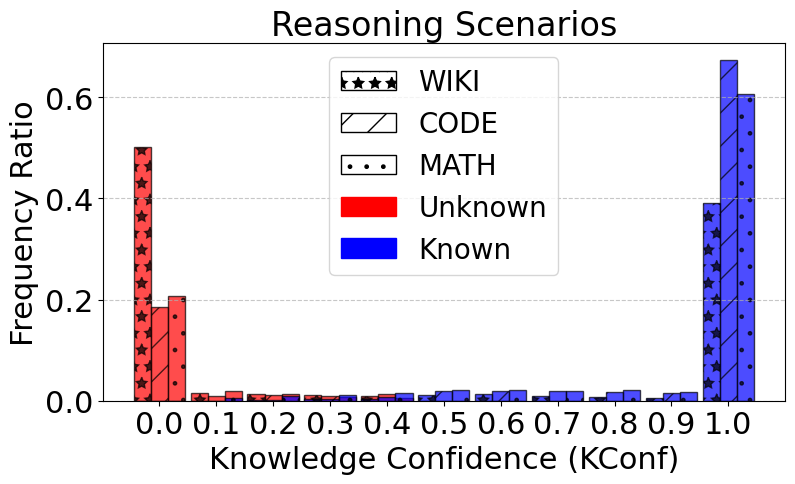

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.patches as mpatches

delta_font=4

# --- Configuration and Data Loading (Same as before) ---
TASK_NAMES = ['grow', 'code', 'math']
MODEL_NAMES = ['llama-3.2-1b', 'llama-3.2-3b', 'llama-3.2-11b', 'qwen-3-1.7b', 'qwen-3-4b', 'qwen-3-8b', 'gpt-4.1-mini', 'o4-mini']
MODEL_MAP = {
    'llama-3.2-1b': 'Llama-3.2 (1B)',
    'llama-3.2-3b': 'Llama-3.2 (3B)',
    'llama-3.2-11b': 'Llama-3.2 (11B)',
    'qwen-3-1.7b': 'Qwen-3 (1.7B)',
    'qwen-3-4b': 'Qwen-3 (4B)',
    'qwen-3-8b': 'Qwen-3 (8B)',
    'gpt-4.1-mini': 'GPT-4.1-mini',
    'o4-mini': 'o4-mini'
}
DATA_DIR = "../data/eval_results"
OUTPUT_DIR = "./plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data... (This part is unchanged)
all_data_records = []
for task in TASK_NAMES:
    for model in MODEL_NAMES:
        file_path = f"{DATA_DIR}/{task}/probe_evaluated/test_500_{model}.pkl"
        try:
            with open(file_path, "rb") as f:
                loaded_data = pickle.load(f)
                for item in loaded_data:
                    all_data_records.append({
                        'task': 'WIKI' if task == 'grow' else task.upper(),
                        'model': MODEL_MAP[model],
                        'knowledgable': item['knowledgable'],
                        'knowledge_confidence': item['knowledge_confidence']
                    })
        except FileNotFoundError:
            print(f"Warning: Data file not found at {file_path}. Skipping.")
df = pd.DataFrame(all_data_records)

# --- Generate the Merged Grouped and Overlapping Bar Chart ---
print("Generating the final merged bar chart...")
fig, ax = plt.subplots(figsize=(8.05, 4.95))

tasks = ['WIKI', 'CODE', 'MATH']
patterns = ['*', '/', '.']
x_positions = np.round(np.arange(0.0, 1.1, 0.1), 1)
bin_edges = np.arange(-0.05, 1.15, 0.1)
n_tasks = len(tasks)
bar_width = 0.09 / n_tasks

for i, task in enumerate(tasks):
    offset = (i - (n_tasks - 1) / 2) * bar_width
    
    task_data = df[df['task'] == task]
    
    unknown_values = task_data[~task_data['knowledgable']]['knowledge_confidence']
    known_values = task_data[task_data['knowledgable']]['knowledge_confidence']
    
    # *** THE FIX: Step 1 - Get raw counts, NOT density ***
    unknown_counts, _ = np.histogram(unknown_values, bins=bin_edges)
    known_counts, _ = np.histogram(known_values, bins=bin_edges)

    # *** THE FIX: Step 2 - Calculate total for this task and compute the ratio manually ***
    total_for_task = len(task_data)
    
    if total_for_task > 0:
        unknown_ratios = unknown_counts / total_for_task
        known_ratios = known_counts / total_for_task
    else:
        # Avoid division by zero if a task has no data
        unknown_ratios = np.zeros_like(unknown_counts, dtype=float)
        known_ratios = np.zeros_like(known_counts, dtype=float)


    # *** THE FIX: Step 3 - Plot the calculated ratios ***
    ax.bar(x_positions + offset, unknown_ratios, width=bar_width, 
           label=f'{task} - Unknown', color='red', alpha=0.7, hatch=patterns[i], edgecolor='black', rasterized=True)
    
    ax.bar(x_positions + offset, known_ratios, width=bar_width, 
           label=f'{task} - Known', color='blue', alpha=0.7, hatch=patterns[i], edgecolor='black', rasterized=True)

# --- Styling and Custom Legend ---
ax.set_title('Reasoning Scenarios', fontsize=20+delta_font)
ax.set_xlabel('Knowledge Confidence (KConf)', fontsize=18+delta_font)
# *** THE FIX: Step 4 - Update the Y-axis label ***
ax.set_ylabel('Frequency Ratio', fontsize=18+delta_font)
ax.set_xticks(x_positions)
ax.set_xticklabels([f"{x:.1f}" for x in x_positions], fontsize=18+delta_font)
ax.tick_params(axis='y', labelsize=18+delta_font)
ax.grid(axis='y', linestyle='--', alpha=0.7)

color_patches = [mpatches.Patch(color='red', alpha=1, label='Unknown'),
                 mpatches.Patch(color='blue', alpha=1, label='Known')]
pattern_patches = [mpatches.Patch(facecolor='white', edgecolor='black', hatch=p, label=t)
                   for t, p in zip(tasks, patterns)]

all_handles = pattern_patches + color_patches
ax.legend(handles=all_handles, loc='upper center', ncol=1, fontsize=16+delta_font)

# --- Save and Show Plot ---
plt.tight_layout()
output_path = os.path.join(OUTPUT_DIR, 'kconf_grouped_overlapping_final.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_path}")

plt.show()

Plot saved to ./plots/kconf_by_model_series.pdf


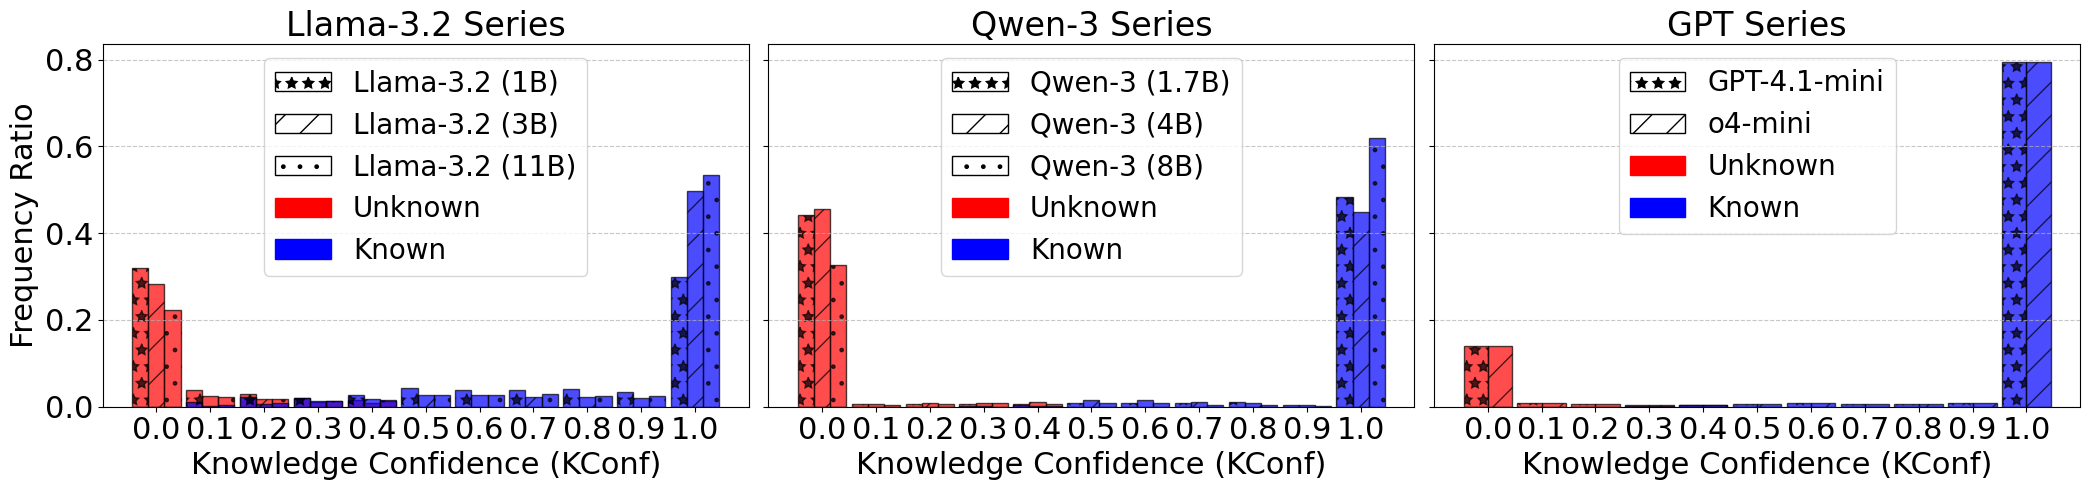

In [6]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.patches as mpatches

# --- Configuration and Data Loading (Same as before) ---
TASK_NAMES = ['grow', 'code', 'math']
MODEL_NAMES = ['llama-3.2-1b', 'llama-3.2-3b', 'llama-3.2-11b', 'qwen-3-1.7b', 'qwen-3-4b', 'qwen-3-8b', 'gpt-4.1-mini', 'o4-mini']
MODEL_MAP = {
    'llama-3.2-1b': 'Llama-3.2 (1B)',
    'llama-3.2-3b': 'Llama-3.2 (3B)',
    'llama-3.2-11b': 'Llama-3.2 (11B)',
    'qwen-3-1.7b': 'Qwen-3 (1.7B)',
    'qwen-3-4b': 'Qwen-3 (4B)',
    'qwen-3-8b': 'Qwen-3 (8B)',
    'gpt-4.1-mini': 'GPT-4.1-mini',
    'o4-mini': 'o4-mini'
}
DATA_DIR = "../data/eval_results"
OUTPUT_DIR = "./plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data...
all_data_records = []
for task in TASK_NAMES:
    for model in MODEL_NAMES:
        file_path = f"{DATA_DIR}/{task}/probe_evaluated/test_500_{model}.pkl"
        try:
            with open(file_path, "rb") as f:
                loaded_data = pickle.load(f)
                for item in loaded_data:
                    all_data_records.append({
                        'task': 'WIKI' if task == 'grow' else task.upper(),
                        'model': MODEL_MAP[model],
                        'knowledgable': item['knowledgable'],
                        'knowledge_confidence': item['knowledge_confidence']
                    })
        except FileNotFoundError:
            print(f"Warning: Data file not found at {file_path}. Skipping.")
df = pd.DataFrame(all_data_records)

# --- Define the Structure for the 1x3 Subplots ---
subplot_definitions = [
    {
        'title': 'Llama-3.2 Series',
        'models_map': { # New Name: Source of data from MODEL_MAP
            'Llama-3.2 (1B)': 'Llama-3.2 (1B)',
            'Llama-3.2 (3B)': 'Llama-3.2 (3B)',
            'Llama-3.2 (11B)': 'Llama-3.2 (11B)' # Placeholder
        },
        'patterns': ['*', '/', '.']
    },
    {
        'title': 'Qwen-3 Series',
        'models_map': {
            'Qwen-3 (1.7B)': 'Qwen-3 (1.7B)', # Placeholder
            'Qwen-3 (4B)': 'Qwen-3 (4B)',   # Placeholder
            'Qwen-3 (8B)': 'Qwen-3 (8B)'    # Placeholder
        },
        'patterns': ['*', '/', '.']
    },
    {
        'title': 'GPT Series',
        'models_map': {
            'GPT-4.1-mini': 'GPT-4.1-mini', # Placeholder
            'o4-mini': 'o4-mini'      # Placeholder
        },
        'patterns': ['*', '/']
    }
]

# --- Generate the 1x3 Figure ---
fig, axes = plt.subplots(1, 3, figsize=(21, 5), sharey=True)
x_positions = np.round(np.arange(0.0, 1.1, 0.1), 1)
bin_edges = np.arange(-0.05, 1.15, 0.1)

# Loop through each subplot definition to create the plots
for ax, definition in zip(axes, subplot_definitions):
    
    # 1. Prepare data for this subplot using placeholders
    plot_data_list = []
    for new_name, source_name in definition['models_map'].items():
        source_df = df[df['model'] == source_name].copy()
        source_df['model'] = new_name
        plot_data_list.append(source_df)
    subplot_df = pd.concat(plot_data_list, ignore_index=True)
    
    # 2. Draw the grouped, overlapping bars
    models_to_plot = list(definition['models_map'].keys())
    patterns_to_use = definition['patterns']
    n_models = len(models_to_plot)
    bar_width = 0.09 / n_models

    for i, model_name in enumerate(models_to_plot):
        offset = (i - (n_models - 1) / 2) * bar_width
        
        model_data = subplot_df[subplot_df['model'] == model_name]
        
        unknown_values = model_data[~model_data['knowledgable']]['knowledge_confidence']
        known_values = model_data[model_data['knowledgable']]['knowledge_confidence']
        
        unknown_counts, _ = np.histogram(unknown_values, bins=bin_edges)
        known_counts, _ = np.histogram(known_values, bins=bin_edges)
        
        total_for_model = len(model_data)
        
        if total_for_model > 0:
            unknown_ratios = unknown_counts / total_for_model
            known_ratios = known_counts / total_for_model
        else:
            unknown_ratios = np.zero_like(unknown_counts, dtype=float)
            known_ratios = np.zero_like(known_counts, dtype=float)

        ax.bar(x_positions + offset, unknown_ratios, width=bar_width, 
               color='red', alpha=0.7, hatch=patterns_to_use[i], edgecolor='black', rasterized=True)
        ax.bar(x_positions + offset, known_ratios, width=bar_width, 
               color='blue', alpha=0.7, hatch=patterns_to_use[i], edgecolor='black', rasterized=True)

    # 3. Style each subplot
    ax.set_title(definition['title'], fontsize=20+delta_font)
    ax.set_xlabel('Knowledge Confidence (KConf)', fontsize=18+delta_font)
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"{x:.1f}" for x in x_positions], fontsize=18+delta_font)
    ax.tick_params(axis='y', labelsize=18+delta_font)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # 4. Create custom legend for each subplot
    color_patches = [mpatches.Patch(color='red', alpha=1, label='Unknown'),
                     mpatches.Patch(color='blue', alpha=1, label='Known')]
    pattern_patches = [mpatches.Patch(facecolor='white', edgecolor='black', hatch=p, label=t)
                       for t, p in zip(models_to_plot, patterns_to_use)]
    
    all_handles = pattern_patches + color_patches
    ax.legend(handles=all_handles, loc='upper center', ncol=1, fontsize=16+delta_font)

axes[0].set_ylabel('Frequency Ratio', fontsize=18+delta_font) # Set Y label only for the first plot

# --- Save and Show Plot ---
plt.tight_layout()
output_path = os.path.join(OUTPUT_DIR, 'kconf_by_model_series.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_path}")

plt.show()

## Knowledge Injection Results

### Main Table

In [5]:
def is_answer_correct(item):
    return item["final_answer_correct"]

def is_reasoning_correct(item):
    return all([k['nli_class'] == 'entailment' for k in item['required_knowledge']])

def is_correct(item):
    return is_answer_correct(item) and is_reasoning_correct(item)

def rate(data, func):
    return sum([func(item) for item in data]) / len(data)

In [7]:
# for task in task_names:
#     for model in model_names:
#         with open(f"../data/eval_results/{task}/injection_evaluated/original_100_{model}_1.pkl", "rb") as f:
#             original_data = pickle.load(f)

#         with open(f"../data/eval_results/{task}/injection_evaluated/all_100_{model}_1.pkl", "rb") as f:
#             all_data_1 = pickle.load(f)
            
#         print(f"Task: {task}")
#         print(f"Model: {model}")
#         print(f"Original: {rate(original_data, is_correct):.2f} (HP) {rate(original_data, is_answer_correct):.2f} (AP) {rate(original_data, is_reasoning_correct):.2f} (FKE)")
#         print(f"Injection (All): {rate(all_data_1, is_correct):.2f} (HP) {rate(all_data_1, is_answer_correct):.2f} (AP) {rate(all_data_1, is_reasoning_correct):.2f} (FKE)")
            
#         for method in method_names:
#             with open(f"../data/eval_results/{task}/injection_evaluated/{method}_100_{model}_1.pkl", "rb") as f:
#                 base_data_1 = pickle.load(f)

#             if method != "rome":
#                 with open(f"../data/eval_results/{task}/injection_evaluated/{method}_100_{model}_10.pkl", "rb") as f:
#                     base_data_10 = pickle.load(f)

#                 with open(f"../data/eval_results/{task}/injection_evaluated/{method}_100_{model}_100.pkl", "rb") as f:
#                     base_data_100 = pickle.load(f)
        
#             print(f"Injection (KAS=1) {method}: {rate(base_data_1, is_correct):.2f} (HP) {rate(base_data_1, is_answer_correct):.2f} (AP) {rate(base_data_1, is_reasoning_correct):.2f} (FKE)")
            
#             if method != "rome":
#                 print(f"Injection (KAS=10) {method}: {rate(base_data_10, is_correct):.2f} (HP) {rate(base_data_10, is_answer_correct):.2f} (AP) {rate(base_data_10, is_reasoning_correct):.2f} (FKE)")
#                 print(f"Injection (KAS=100) {method}: {rate(base_data_100, is_correct):.2f} (HP) {rate(base_data_100, is_answer_correct):.2f} (AP) {rate(base_data_100, is_reasoning_correct):.2f} (FKE)")

for task in task_names:
    for model in model_names:
        # with open(f"../data/eval_results/{task}/injection_evaluated/original_500_{model}_1.pkl", "rb") as f:
        #     original_data = pickle.load(f)

        # with open(f"../data/eval_results/{task}/injection_evaluated/all_500_{model}_1.pkl", "rb") as f:
        #     all_data_1 = pickle.load(f)
            
        print(f"Task: {task}")
        print(f"Model: {model}")
        # print(f"Original: {rate(original_data, is_correct):.2f} (HP) {rate(original_data, is_answer_correct):.2f} (AP) {rate(original_data, is_reasoning_correct):.2f} (FKE)")
        # print(f"Injection (All): {rate(all_data_1, is_correct):.2f} (HP) {rate(all_data_1, is_answer_correct):.2f} (AP) {rate(all_data_1, is_reasoning_correct):.2f} (FKE)")
            
        for method in method_names:
            with open(f"../data/eval_results/{task}/injection_evaluated/{method}_500_{model}_1.pkl", "rb") as f:
                base_data_1 = pickle.load(f)

            if method != "rome":
                with open(f"../data/eval_results/{task}/injection_evaluated/{method}_500_{model}_10.pkl", "rb") as f:
                    base_data_10 = pickle.load(f)

                with open(f"../data/eval_results/{task}/injection_evaluated/{method}_500_{model}_100.pkl", "rb") as f:
                    base_data_100 = pickle.load(f)
                    
                with open(f"../data/eval_results/{task}/injection_evaluated/{method}_500_{model}_500.pkl", "rb") as f:
                    base_data_500 = pickle.load(f)
        
            print(f"Injection (KAS=1) {method}: {rate(base_data_1, is_correct):.2f} (HP) {rate(base_data_1, is_answer_correct):.2f} (AP) {rate(base_data_1, is_reasoning_correct):.2f} (FKE)")
            
            if method != "rome":
                print(f"Injection (KAS=10) {method}: {rate(base_data_10, is_correct):.2f} (HP) {rate(base_data_10, is_answer_correct):.2f} (AP) {rate(base_data_10, is_reasoning_correct):.2f} (FKE)")
                print(f"Injection (KAS=100) {method}: {rate(base_data_100, is_correct):.2f} (HP) {rate(base_data_100, is_answer_correct):.2f} (AP) {rate(base_data_100, is_reasoning_correct):.2f} (FKE)")
                print(f"Injection (KAS=500) {method}: {rate(base_data_500, is_correct):.2f} (HP) {rate(base_data_500, is_answer_correct):.2f} (AP) {rate(base_data_500, is_reasoning_correct):.2f} (FKE)")

Task: grow
Model: gpt-4.1-mini
Injection (KAS=1) base: 0.71 (HP) 0.94 (AP) 0.71 (FKE)
Injection (KAS=10) base: 0.70 (HP) 0.91 (AP) 0.71 (FKE)
Injection (KAS=100) base: 0.72 (HP) 0.94 (AP) 0.73 (FKE)
Injection (KAS=500) base: 0.71 (HP) 0.89 (AP) 0.71 (FKE)
Task: grow
Model: o4-mini
Injection (KAS=1) base: 0.80 (HP) 0.94 (AP) 0.80 (FKE)
Injection (KAS=10) base: 0.80 (HP) 0.94 (AP) 0.80 (FKE)
Injection (KAS=100) base: 0.78 (HP) 0.95 (AP) 0.78 (FKE)
Injection (KAS=500) base: 0.78 (HP) 0.94 (AP) 0.78 (FKE)
Task: code
Model: gpt-4.1-mini
Injection (KAS=1) base: 0.37 (HP) 0.49 (AP) 0.73 (FKE)
Injection (KAS=10) base: 0.34 (HP) 0.45 (AP) 0.65 (FKE)
Injection (KAS=100) base: 0.37 (HP) 0.49 (AP) 0.70 (FKE)
Injection (KAS=500) base: 0.35 (HP) 0.48 (AP) 0.67 (FKE)
Task: code
Model: o4-mini
Injection (KAS=1) base: 0.40 (HP) 0.48 (AP) 0.77 (FKE)
Injection (KAS=10) base: 0.38 (HP) 0.47 (AP) 0.76 (FKE)
Injection (KAS=100) base: 0.38 (HP) 0.47 (AP) 0.76 (FKE)
Injection (KAS=500) base: 0.39 (HP) 0.49 (A

### Answer Pass and Full Knowledge Entailment

In [ ]:
def get_transition_counts(data_list, is_answer_correct_func, is_reasoning_correct_func):
    transition_counts = np.zeros((2, 2), dtype=int)
    if not data_list: 
        return transition_counts
    for item in data_list:
        if not isinstance(item, dict):
            continue
        ans_correct = is_answer_correct_func(item)
        reas_correct = is_reasoning_correct_func(item)
        if reas_correct:
            if ans_correct:
                transition_counts[0, 0] += 1
            else:
                transition_counts[0, 1] += 1
        else:
            if ans_correct:
                transition_counts[1, 0] += 1
            else:
                transition_counts[1, 1] += 1
    return transition_counts


# --- Data Aggregation (unchanged) ---
models = ["llama-3.2-1b", "llama-3.2-3b", "qwen-2.5-1.5b", "qwen-2.5-3b"]
tasks = ['grow', 'code', 'math']
scopes = [1, 10, 100]
all_task_counts = {}

for task in tasks:
    aggregated_counts = np.zeros((2, 2), dtype=int)
    base_file_dir = f"../data/eval_results/{task}/injection_evaluated/"
    print(f"\n--- Processing Task: {task.upper()} ---")
    for model in models:
        for scope in scopes:
            file_name = f"base_100_{model}_{scope}.pkl"
            file_path = os.path.join(base_file_dir, file_name)
            try:
                with open(file_path, "rb") as f:
                    data = pickle.load(f)
                transition_counts = get_transition_counts(data, is_correct, is_reasoning_correct)
                aggregated_counts += transition_counts
            except FileNotFoundError:
                pass 
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    all_task_counts[task] = aggregated_counts


# ===================================================================
# 2. Sankey Visualization Function (unchanged)
# ===================================================================
def create_sankey_amcharts(count_matrix, task_name, source_labels, target_labels):
    source_totals = count_matrix.sum(axis=1)
    target_totals = count_matrix.sum(axis=0)
    total_flow = count_matrix.sum()
    links_data = []
    if total_flow > 0:
        source_final_labels = {
            label: f"{label}\n{(source_totals[i] / total_flow) * 100:.1f}%"
            for i, label in enumerate(source_labels)
        }
        target_final_labels = {
            label: f"{label}\n{(target_totals[i] / total_flow) * 100:.1f}%"
            for i, label in enumerate(target_labels)
        }
        for i, source_label_base in enumerate(source_labels):
            for j, target_label_base in enumerate(target_labels):
                value = count_matrix[i, j]
                if value > 0:
                    links_data.append({
                        "from": source_final_labels[source_label_base], 
                        "to": target_final_labels[target_label_base], 
                        "value": int(value)
                    })
    sankey_data_json = json.dumps(links_data)
    html_template = f"""
    <script src="https://cdn.jsdelivr.net/npm/twemoji@14.0.2/dist/twemoji.min.js"></script>
    <script>
    am5.ready(function () {{
      var root = am5.Root.new("chartdiv1-{task_name}");
      root.setThemes([am5themes_Animated.new(root)]);
      var series = root.container.children.push(
        am5flow.Sankey.new(root, {{
          sourceIdField: "from",
          targetIdField: "to",
          valueField: "value",
          nodePadding: 15,
          paddingRight: 50,
          paddingTop: 50
        }})
      );
      series.nodes.labels.template.setAll({{
        fontWeight: "bold",
        fontSize: 43,
        fontFamily: "DejaVu Sans",
        x: am5.p50,
        paddingLeft: 15,
        paddingRight: 15,
      }});
      series.nodes.labels.template.adapters.add("centerX", function (center, target) {{
        if (target.dataItem.get("incomingLinks", []).length === 0) {{
          return am5.p0;
        }} else if (target.dataItem.get("outgoingLinks", []).length === 0) {{
          return am5.p100;
        }}
        return am5.p50;
      }});
      series.set("nodeWidth", 20);
      function getNodeColor(name) {{
        var n = name || "";
        if (n.includes("\u274e")) return am5.color(0xff6666);
        if (n.includes("\u2705")) return am5.color(0x66cc66);
        return am5.color(0x88aaff);
      }}
      series.nodes.rectangles.template.setAll({{ fillOpacity: 1 }});
      series.nodes.rectangles.template.adapters.add("fill", function(fill, target) {{
        var nodeName = target.dataItem.get("name") || "";
        return getNodeColor(nodeName);
      }});
      var linkTemplate = series.links.template;
      linkTemplate.setAll({{
        fillOpacity: 0.9,
        strokeOpacity: 0.9,
        strokeWidth: 1
      }});
      linkTemplate.states.create("hover", {{ fillOpacity: 1 }});
      linkTemplate.adapters.add("fillGradient", function(fillGradient, link) {{
        var sourceNode = link.dataItem.get("source");
        var targetNode = link.dataItem.get("target");
        if (!sourceNode || !targetNode) return fillGradient;
        var sourceColor = getNodeColor(sourceNode.get("name") || "");
        var targetColor = getNodeColor(targetNode.get("name") || "");
        var gradient = am5.LinearGradient.new(root, {{
          stops: [ {{ color: sourceColor }}, {{ color: targetColor }} ],
          rotation: 0
        }});
        return gradient;
      }});
      linkTemplate.adapters.add("strokeGradient", function(strokeGradient, link) {{
        return link.get("fillGradient");
      }});
      series.data.setAll({sankey_data_json});
      series.appear(1000, 100).then(function() {{
        twemoji.parse(document.getElementById("chartdiv1-{task_name}"), {{
          folder: 'svg',
          ext: '.svg'
        }});
      }});
    }});
    </script>
    <div id="chartdiv1-{task_name}" style="width: 50%; height: 500px; background-color: #FFFFFF;"></div>
    """
    return HTML(html_template)


# ===================================================================
# 3. Plotting (with a new check to prevent blank charts)
# ===================================================================

source_labels = ['✅ % FKE', '❎ % FKE']
target_labels = ['✅ % HP', '❎ % HP']

display(HTML("""
<script src="https://cdn.amcharts.com/lib/5/index.js"></script>
<script src="https://cdn.amcharts.com/lib/5/flow.js"></script>
<script src="https://cdn.amcharts.com/lib/5/themes/Animated.js"></script>
"""))

for task, count_matrix in all_task_counts.items():
    print(f"--- Sankey Diagram for Task: {task.capitalize()} ---")
    
    # NEW: Check if there is any data to plot before creating the chart
    if count_matrix.sum() == 0:
        print("Skipping plot: No data was aggregated for this task. Please check file paths and data keys.")
        continue

    sankey_chart = create_sankey_amcharts(count_matrix, task, source_labels, target_labels)
    display(sankey_chart)


--- Processing Task: GROW ---

--- Processing Task: CODE ---

--- Processing Task: MATH ---


--- Sankey Diagram for Task: Grow ---


--- Sankey Diagram for Task: Code ---


--- Sankey Diagram for Task: Math ---


### Knowledge-Level Transition

In [ ]:
MAX_EXAMPLES_PER_TYPE = 5

# Your data analysis code remains the same...
def analyze_knowledge_level_transitions(dataset):
    counts = np.zeros((2, 3), dtype=int)
    if not dataset: return counts
    for item in dataset:
        if 'required_knowledge' not in item: continue
        failure_has_occurred = False
        for fact in item['required_knowledge']:
            if 'knowledgable' not in fact or 'nli_class' not in fact: continue
            source_row_idx = 1 if not fact['knowledgable'] else 0
            is_entailed = (str(fact['nli_class']).lower() == 'entailment')
            if is_entailed:
                target_col_idx = 0
            else:
                target_col_idx = 2 if failure_has_occurred else 1
                failure_has_occurred = True
            counts[source_row_idx, target_col_idx] += 1
    return counts

tasks = ['grow', 'code', 'math']
models_to_process = ["llama-3.2-1b", "llama-3.2-3b", "qwen-2.5-1.5b", "qwen-2.5-3b"]
base_scopes_to_aggregate = [1, 10, 100]
all_task_matrices = {}
all_task_examples = {}

print("--- Data Analysis ---")
for task in tasks:
    aggregated_task_counts = np.zeros((2, 3), dtype=int)
    examples_found_for_task = {
        "entail": [],
        "direct_failure": [],
        "error_propagation": []
    }
    base_path = f"../data/eval_results/{task}/injection_evaluated/"
    for model in models_to_process:
        for scope in base_scopes_to_aggregate:
            file_name = f"base_100_{model}_{scope}.pkl"
            file_path = os.path.join(base_path, file_name)
            try:
                with open(file_path, "rb") as f: data = pickle.load(f)
                aggregated_task_counts += analyze_knowledge_level_transitions(data)
                if not all(len(lst) >= MAX_EXAMPLES_PER_TYPE for lst in examples_found_for_task.values()):
                    for item in data:
                        # Add item only once per category, even if it has multiple facts of that category
                        item_already_added_for = {"entail": False, "direct_failure": False, "error_propagation": False}

                        if 'required_knowledge' not in item or not item['required_knowledge']: continue
                        failure_has_occurred = False
                        
                        for fact in item['required_knowledge']:
                            if 'nli_class' not in fact: continue
                            is_entailed = (str(fact['nli_class']).lower() == 'entailment')

                            if is_entailed:
                                if not item_already_added_for["entail"] and len(examples_found_for_task["entail"]) < MAX_EXAMPLES_PER_TYPE:
                                    examples_found_for_task["entail"].append(item)
                                    item_already_added_for["entail"] = True
                            else:
                                if not failure_has_occurred: # Direct Failure
                                    if not item_already_added_for["direct_failure"] and len(examples_found_for_task["direct_failure"]) < MAX_EXAMPLES_PER_TYPE:
                                        examples_found_for_task["direct_failure"].append(item)
                                        item_already_added_for["direct_failure"] = True
                                    failure_has_occurred = True
                                else: # Error Propagation
                                    if not item_already_added_for["error_propagation"] and len(examples_found_for_task["error_propagation"]) < MAX_EXAMPLES_PER_TYPE:
                                        examples_found_for_task["error_propagation"].append(item)
                                        item_already_added_for["error_propagation"] = True
                        
                        if all(len(lst) >= MAX_EXAMPLES_PER_TYPE for lst in examples_found_for_task.values()): break

            except FileNotFoundError:
                pass
    all_task_matrices[task] = aggregated_task_counts
    all_task_examples[task] = examples_found_for_task
print("--- Data Analysis Complete ---")


# ===================================================================
# Python function that STRICTLY follows the user-provided JS template
# ===================================================================

def create_sankey_amcharts(count_matrix, task_name, source_labels, target_labels):
    """
    Generates a Sankey plot by formatting data in Python and injecting it
    into a JavaScript template that is a literal copy of the user's code.
    """
    
    # --- 1. Python: Pre-calculate and Pre-format data ---
    source_totals = count_matrix.sum(axis=1)
    target_totals = count_matrix.sum(axis=0)
    total_flow = count_matrix.sum()

    links_data = []
    if total_flow > 0:
        # Create a dictionary to hold the pre-formatted labels to avoid re-calculating
        source_final_labels = {
            label: f"{label}{(source_totals[i] / total_flow) * 100:.1f}%"
            for i, label in enumerate(source_labels)
        }
        target_final_labels = {
            label: f"{label}{(target_totals[i] / total_flow) * 100:.1f}%"
            for i, label in enumerate(target_labels)
        }
        
        for i, source_label_base in enumerate(source_labels):
            for j, target_label_base in enumerate(target_labels):
                value = count_matrix[i, j]
                if value > 0:
                    links_data.append({
                        "from": source_final_labels[source_label_base], 
                        "to": target_final_labels[target_label_base], 
                        "value": int(value)
                    })

    # Convert the final data structure to a JSON string
    sankey_data_json = json.dumps(links_data)

    # --- 2. Create the HTML/JS template, as a literal copy of the user's code ---
    html_template = f"""
    <script src="https://cdn.jsdelivr.net/npm/twemoji@14.0.2/dist/twemoji.min.js"></script>
    
    <script>
    am5.ready(function () {{
      var root = am5.Root.new("chartdiv-{task_name}");
      root.setThemes([am5themes_Animated.new(root)]);
    
      var series = root.container.children.push(
        am5flow.Sankey.new(root, {{
          sourceIdField: "from",
          targetIdField: "to",
          valueField: "value",
          nodePadding: 15,
          paddingRight: 50,
          paddingTop: 50
        }})
      );
      
      series.nodes.labels.template.setAll({{
        fontWeight: "bold",
        fontSize: 33, // Copied from your Python code, you can change it to 53 if preferred
        fontFamily: "DejaVu Sans",
        x: am5.p50,
        paddingLeft: 15,
        paddingRight: 15,
      }});
    
      series.nodes.labels.template.adapters.add("centerX", function (center, target) {{
        if (target.dataItem.get("incomingLinks", []).length === 0) {{
          return am5.p0;
        }} else if (target.dataItem.get("outgoingLinks", []).length === 0) {{
          return am5.p100;
        }}
        return am5.p50;
      }});
    
      series.set("nodeWidth", 20);
    
      function getNodeColor(name) {{
        var n = name || "";
        if (n.includes("\u274e")) return am5.color(0xff6666);
        if (n.includes("\u2705")) return am5.color(0x66cc66);
        return am5.color(0x88aaff);
      }}
    
      series.nodes.rectangles.template.setAll({{ fillOpacity: 1 }});
      series.nodes.rectangles.template.adapters.add("fill", function(fill, target) {{
        var nodeName = target.dataItem.get("name") || "";
        return getNodeColor(nodeName);
      }});
    
      var linkTemplate = series.links.template;
      linkTemplate.setAll({{
        fillOpacity: 0.9,
        strokeOpacity: 0.9,
        strokeWidth: 1
      }});
      linkTemplate.states.create("hover", {{ fillOpacity: 1 }});

      linkTemplate.adapters.add("fillGradient", function(fillGradient, link) {{
        var sourceNode = link.dataItem.get("source");
        var targetNode = link.dataItem.get("target");
        if (!sourceNode || !targetNode) return fillGradient;
    
        var sourceColor = getNodeColor(sourceNode.get("name") || "");
        var targetColor = getNodeColor(targetNode.get("name") || "");
        var gradient = am5.LinearGradient.new(root, {{
          stops: [ {{ color: sourceColor }}, {{ color: targetColor }} ],
          rotation: 0
        }});
        return gradient;
      }});
      linkTemplate.adapters.add("strokeGradient", function(strokeGradient, link) {{
        return link.get("fillGradient");
      }});
    
      series.data.setAll({sankey_data_json});
    
      series.appear(1000, 100).then(function() {{
        twemoji.parse(document.getElementById("chartdiv-{task_name}"), {{
          folder: 'svg',
          ext: '.svg'
        }});
      }});
    }});
    </script>
    
    <div id="chartdiv-{task_name}" style="width: 60%; height: 500px; background-color: #FFFFFF;"></div>
    """
    
    return HTML(html_template)

# --- Your Main Interface Configuration ---
source_labels = ['Known\n✅ ', 'Unknown\n❎ ']
target_labels = ['Entail\n✅ ', 'Direct Failure\n❎ ', 'Error Propagation\n➡️ ']

# --- Re-run the generation of the plots ---
display(HTML("""
<script src="https://cdn.amcharts.com/lib/5/index.js"></script>
<script src="https://cdn.amcharts.com/lib/5/flow.js"></script>
<script src="https://cdn.amcharts.com/lib/5/themes/Animated.js"></script>
"""))

for task, matrix in all_task_matrices.items():
    print(f"--- Sankey Diagram for Task: {task.capitalize()} ---")
    # The color_map argument is no longer needed
    sankey_chart = create_sankey_amcharts(matrix, task, source_labels, target_labels)
    display(sankey_chart)

--- Data Analysis ---
--- Data Analysis Complete ---


--- Sankey Diagram for Task: Grow ---


--- Sankey Diagram for Task: Code ---


--- Sankey Diagram for Task: Math ---


In [13]:
all_task_examples['grow']['entail']

[{'id': 3,
  'question': 'What kind of work does the person who is the current head of government of the capital of the country of citizenship of Seifeddine Bali do?',
  'answer': 'magistrate',
  'required_knowledge': [{'knowledge': 'Seifeddine Bali is a citizen of Tunisia.',
    'knowledgable': False,
    'knowledge_confidence': 0.0,
    'nli_class': 'neutral',
    'nli_explanation': "Neutral. The context states that the country or region named Seifeddine Bali is unknown or not well-known, but it does not provide any information about Seifeddine Bali's citizenship or whether they are a citizen of Tunisia. Therefore, the statement about Seifeddine Bali being a citizen of Tunisia is neither confirmed nor contradicted by the context."},
   {'knowledge': 'The capital of Tunisia is Tunis.',
    'knowledgable': True,
    'knowledge_confidence': 1.0,
    'nli_class': 'entailment',
    'nli_explanation': "Entailment. Although the context states that the country or region named Seifeddine Bali

In [ ]:
reasoning_incorrect = {
    "grow": [],
    "math": [],
    "code": []
}
task_names = ["grow", "math", "code"]
for task in task_names:
    with open(f"../data/eval_results/{task}/injection_evaluated/mello_100_llama-3.2-1b_1.pkl", "rb") as f: data = pickle.load(f)
    for d in data:
        full_knowledge_entail = all([k["nli_class"] == "entailment" for k in d["required_knowledge"]])
        if full_knowledge_entail and (not d["final_answer_correct"]):
            reasoning_incorrect[task].append(d)

In [10]:
reasoning_incorrect["grow"]

[]